In [1]:
import json
with open('training_data/train.json', 'r') as file:
    train_data = json.load(file)

In [2]:
print(train_data)

{'5bc844fc-e852-4270-bfaf-36ea9eface3d': {'Type': 'Comparison', 'Section_id': 'Intervention', 'Primary_id': 'NCT01928186', 'Secondary_id': 'NCT00684983', 'Statement': 'All the primary trial participants do not receive any oral capecitabine, oral lapatinib ditosylate or cixutumumab IV, in conrast all the secondary trial subjects receive these.', 'Label': 'Contradiction'}, '86b7cb3d-6186-4a04-9aa6-b174ab764eed': {'Type': 'Single', 'Section_id': 'Eligibility', 'Primary_id': 'NCT00662129', 'Statement': 'Patients with Platelet count over 100,000/mm¬¨‚â•, ANC <  1,700/mm¬¨‚â• and Hemoglobin between 4 to 5 grams per deciliter are eligible for the primary trial.', 'Label': 'Contradiction'}, 'dbed5471-c2fc-45b5-b26f-430c9fa37a37': {'Type': 'Comparison', 'Section_id': 'Adverse Events', 'Primary_id': 'NCT00093145', 'Secondary_id': 'NCT00703326', 'Statement': 'Heart-related adverse events were recorded in both the primary trial and the secondary trial.', 'Label': 'Entailment'}, '20c35c89-8d23-4be3

In [3]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [8]:
label_mapping = {
    'Entailment': 0,
    'Contradiction': 1
}

In [9]:
import os, re
def preprocess_data(train_data):
    preprocessed_data=[]
    for data_id, data in train_data.items():
        ctr_1 = data['Primary_id']+ '.json'
        ctr_1f = os.path.join("training_data/CT json", ctr_1)
        secondaryid_exists = False
        if 'Secondary_id' in data:
            ctr_2 = data['Secondary_id']+ '.json'
            ctr_2f = os.path.join("training_data/CT json", ctr_2)
            secondaryid_exists = True


        with open(ctr_1f, 'r') as file:
            ctr_a = json.load(file)
            if secondaryid_exists:
                with open(ctr_2f, 'r') as file:
                    ctr_b = json.load(file)
                ctr = " [SEP] ".join(ctr_a[data['Section_id']]) +" [SEP] " + " [SEP] ".join(ctr_b[data["Section_id"]]) + " [SEP] " + data["Statement"]
            else:
                ctr = " [SEP] ".join(ctr_a[data['Section_id']]) + " [SEP] " + data["Statement"]
        ctr = ctr.lower()
        url_ptrn = r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
        

        ctr = re.sub(url_ptrn, '', ctr)
        ctr = re.sub(r'[^\w\s]','', ctr)

        inputs = tokenizer(ctr, return_tensors='pt', max_length=512, padding='max_length', truncation=True)
        labels = torch.tensor([label_mapping[data['Label']]])


        preprocessed_data.append((inputs, labels))
    return preprocessed_data
    




In [7]:
from torch.utils.data import DataLoader

batch_size = 128
preprocessed_data = preprocess_data(train_data)
train_loader = DataLoader(preprocessed_data, batch_size=batch_size)

In [10]:
import json
import os, re
with open('training_data/dev.json', 'r') as file:
    dev_data = json.load(file)

dev_preprocessed_data= preprocess_data(dev_data)

    

In [11]:
from torch.utils.data import DataLoader

batch_size = 128
val_loader = DataLoader(dev_preprocessed_data, batch_size=batch_size)

In [13]:
for param in list(model.parameters())[:-4]:
    param.requires_grad = False

In [37]:

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
from sklearn.metrics import accuracy_score


device = torch.device('mps')

model.to(device)


# Training loop
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
NUM_EPOCHS=50
import time

for epoch in range(NUM_EPOCHS):
    # Training
    model.train()
    total_train_loss = 0.0
    correct_train = 0
    total_train = 0
    train_predicted = []
    train_labels = []
    for batch in train_loader:
        # start = time.time()
        input_ids = batch[0]['input_ids']
        attention_mask = batch[0]['attention_mask']

        labels = batch[1].to(device)
        input_ids = input_ids.squeeze(1).to(device)
        attention_mask = attention_mask.squeeze(1).to(device)
        optimizer.zero_grad()
       
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_train_loss += loss.item()
        loss.backward()
        optimizer.step()
        _, predicted = torch.max(outputs.logits, 1)
        train_predicted.extend(predicted.tolist())
        train_labels.extend(labels.tolist())
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
        

    train_loss = total_train_loss / len(train_loader)
    train_acc_score = accuracy_score(train_labels, train_predicted)
    
    train_losses.append(train_loss)
    train_accuracies.append(train_acc_score)
    

    # Validation
    model.eval()
    total_val_loss = 0.0
    correct_val = 0
    total_val = 0
    val_predicted = []
    val_labels = []

    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch[0]['input_ids']
            attention_mask = batch[0]['attention_mask']

            labels = batch[1].to(device)
            input_ids = input_ids.squeeze(1).to(device)
            attention_mask = attention_mask.squeeze(1).to(device)
            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            total_val_loss += loss.item()
            _, predicted = torch.max(outputs.logits, 1)
            val_predicted.extend(predicted.tolist())
            val_labels.extend(labels.tolist())
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_loss = total_val_loss / len(val_loader)
    val_acc_score = accuracy_score(val_labels, val_predicted)
    
    val_losses.append(val_loss)
    val_accuracies.append(val_acc_score)

    print(f'Epoch {epoch + 1}/{NUM_EPOCHS}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc_score:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc_score:.4f}')

Epoch 1/50, Train Loss: 0.6978, Train Accuracy: 0.5000, Val Loss: 0.6940, Val Accuracy: 0.5000
Epoch 2/50, Train Loss: 0.6979, Train Accuracy: 0.5053, Val Loss: 0.6938, Val Accuracy: 0.5200
Epoch 3/50, Train Loss: 0.6929, Train Accuracy: 0.5094, Val Loss: 0.6947, Val Accuracy: 0.5250
Epoch 4/50, Train Loss: 0.6955, Train Accuracy: 0.4965, Val Loss: 0.6941, Val Accuracy: 0.5150
Epoch 5/50, Train Loss: 0.6962, Train Accuracy: 0.4882, Val Loss: 0.6938, Val Accuracy: 0.5300
Epoch 6/50, Train Loss: 0.6922, Train Accuracy: 0.5112, Val Loss: 0.6934, Val Accuracy: 0.5050
Epoch 7/50, Train Loss: 0.6910, Train Accuracy: 0.5200, Val Loss: 0.6931, Val Accuracy: 0.5100
Epoch 8/50, Train Loss: 0.6939, Train Accuracy: 0.5041, Val Loss: 0.6936, Val Accuracy: 0.5200
Epoch 9/50, Train Loss: 0.6924, Train Accuracy: 0.5035, Val Loss: 0.6928, Val Accuracy: 0.5250
Epoch 10/50, Train Loss: 0.6936, Train Accuracy: 0.5035, Val Loss: 0.6923, Val Accuracy: 0.5300
Epoch 11/50, Train Loss: 0.6916, Train Accuracy: 

In [38]:
torch.save(model.state_dict(), 'siri_NLP_model_state.pth')

In [39]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

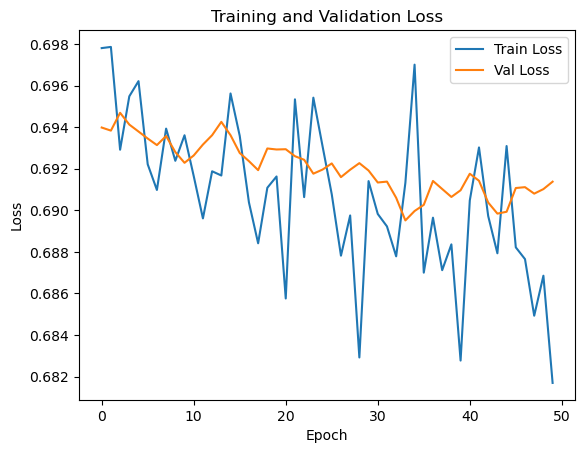

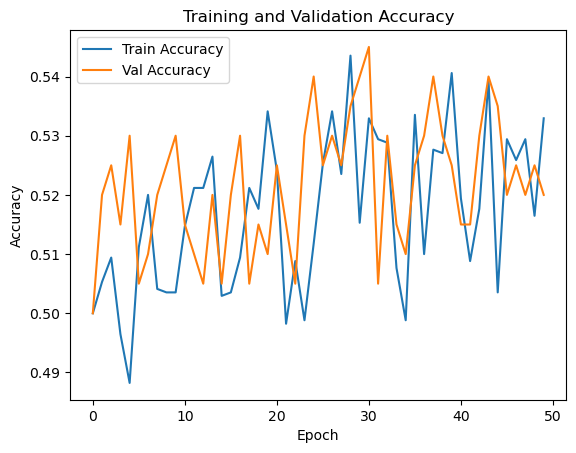

In [40]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label='Train Loss')
plt.plot( val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

plt.plot( train_accuracies, label='Train Accuracy')
plt.plot( val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

In [41]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

model.eval()
predictions = []
true_labels = []

with torch.no_grad():
    for batch in val_loader:
        input_ids = batch[0]['input_ids']
        attention_mask = batch[0]['attention_mask']
        labels = batch[1].to(device)
        input_ids = input_ids.squeeze(1).to(device)
        attention_mask = attention_mask.squeeze(1).to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        _, predicted = torch.max(outputs.logits, 1)
        predictions.extend(predicted.tolist())
        true_labels.extend(labels.tolist())

true_labels = np.array(true_labels)
predictions = np.array(predictions)

accuracy = accuracy_score(true_labels, predictions)
print(f'Accuracy: {accuracy:.4f}')

precision = precision_score(true_labels, predictions, average='weighted')
recall = recall_score(true_labels, predictions, average='weighted')
f1 = f1_score(true_labels, predictions, average='weighted')

print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}')

labels = ['Precision', 'Recall', 'F1 Score']
scores = [precision, recall, f1]


Accuracy: 0.5200
Precision: 0.5212, Recall: 0.5200, F1 Score: 0.5130


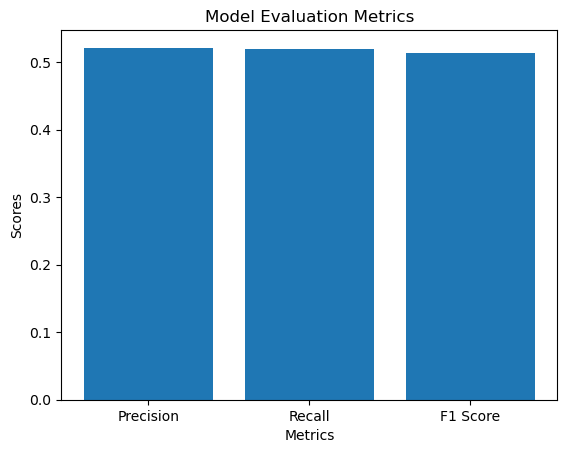

In [42]:

plt.bar(labels, scores)
plt.xlabel('Metrics')
plt.ylabel('Scores')
plt.title('Model Evaluation Metrics')
plt.show()




In [43]:
flat_list = [item for sublist in true_labels for item in sublist]
print(flat_list)

[1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1]


In [44]:
if len(flat_list) != len(predictions):
        raise ValueError("The lists of predictions must have the same length.")
faithfulness = sum(abs(o - c) for o, c in zip(flat_list, predictions)) / len(flat_list)

In [45]:
print(faithfulness)

0.48


In [46]:
if len(true_labels) != len(predictions):
        raise ValueError("The lists of predictions must have the same length.")
faithfulness = sum(abs(o - c) for o, c in zip(true_labels, predictions)) / len(true_labels)

In [47]:
print(faithfulness)

[0.48]


In [48]:
if len(true_labels) != len(predictions):
        raise ValueError("The lists of predictions must have the same length.")
consistency = sum(1-abs(o - c) for o, c in zip(true_labels, predictions)) / len(true_labels)

In [49]:
print(consistency)

[0.52]


In [50]:
import json
with open('test.json', 'r') as file:
    test_data = json.load(file)

In [51]:
test_preprocessed_data=[]
for data_id, data in test_data.items():
    ctr_1 = data['Primary_id']+ '.json'
    ctr_1f = os.path.join("training_data/CT json", ctr_1)
    secondaryid_exists = False
    if 'Secondary_id' in data:
        ctr_2 = data['Secondary_id']+ '.json'
        ctr_2f = os.path.join("training_data/CT json", ctr_2)
        secondaryid_exists = True


    with open(ctr_1f, 'r') as file:
        ctr_a = json.load(file)
        if secondaryid_exists:
            with open(ctr_2f, 'r') as file:
                ctr_b = json.load(file)
            ctr = " ".join(ctr_a[data['Section_id']]) +" [SEP] "+ " ".join(ctr_b[data["Section_id"]]) + " [SEP] " + data["Statement"]
        else:
            ctr = " ".join(ctr_a[data['Section_id']]) + " [SEP] " + data["Statement"]
    ctr = ctr.lower()
    url_ptrn = r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'

    ctr = re.sub(url_ptrn, '', ctr)
    ctr = re.sub(r'[^\w\s]','', ctr)

    inputs = tokenizer(ctr, return_tensors='pt', max_length=512, padding='max_length', truncation=True)
    
    test_preprocessed_data.append(inputs)

In [52]:
from torch.utils.data import DataLoader

batch_size = 128
test_data_loader = DataLoader(test_preprocessed_data, batch_size=batch_size)

In [ ]:
model.eval()
predictions = []

with torch.no_grad():
    for batch in test_data_loader:
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        input_ids = input_ids.squeeze(1).to(device)
        attention_mask = attention_mask.squeeze(1).to(device)
        outputs = model(input_ids, attention_mask=attention_mask)
        _, predicted = torch.max(outputs.logits, 1)
        predictions.extend(predicted.tolist())
        

In [54]:
list(set(predictions))

[0, 1]

In [55]:
predictions

[1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,


In [5]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [6]:
model.load_state_dict(torch.load('milestone2_NLP_model_state.pth'))

model.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [5]:
import json
with open('gold_practice_test.json', 'r') as file:
    gold_practice_test = json.load(file)

In [6]:
gold_test = preprocess_data(gold_practice_test)

In [26]:
from torch.utils.data import DataLoader

batch_size = 64
gold_test_loader = DataLoader(gold_test, batch_size=batch_size)

In [12]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

model.eval()
predictions = []
true_labels = []

with torch.no_grad():
    for batch in val_loader:
        input_ids = batch[0]['input_ids']
        attention_mask = batch[0]['attention_mask']
        labels = batch[1]
        input_ids = input_ids.squeeze(1)
        attention_mask = attention_mask.squeeze(1)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        _, predicted = torch.max(outputs.logits, 1)
        predictions.extend(predicted.tolist())
        true_labels.extend(labels.tolist())


In [13]:
import numpy as np

true_labels = np.array(true_labels)
predictions = np.array(predictions)

accuracy = accuracy_score(true_labels, predictions)
print(f'Accuracy: {accuracy:.4f}')

precision = precision_score(true_labels, predictions, average='weighted')
recall = recall_score(true_labels, predictions, average='weighted')
f1 = f1_score(true_labels, predictions, average='weighted')

print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}')

labels = ['Precision', 'Recall', 'F1 Score']
scores = [precision, recall, f1]


Accuracy: 0.5200
Precision: 0.5212, Recall: 0.5200, F1 Score: 0.5130


In [14]:
if len(true_labels) != len(predictions):
        raise ValueError("The lists of predictions must have the same length.")
faithfulness = sum(abs(o - c) for o, c in zip(true_labels, predictions)) / len(true_labels)

print(faithfulness)

[0.48]


In [15]:
if len(true_labels) != len(predictions):
        raise ValueError("The lists of predictions must have the same length.")
consistency = sum(1-abs(o - c) for o, c in zip(true_labels, predictions)) / len(true_labels)

print(consistency)

[0.52]


In [30]:
import numpy as np

true_labels = np.array(true_labels)
predictions = np.array(predictions)

accuracy = accuracy_score(true_labels, predictions)
print(f'Accuracy: {accuracy:.4f}')

precision = precision_score(true_labels, predictions, average='weighted')
recall = recall_score(true_labels, predictions, average='weighted')
f1 = f1_score(true_labels, predictions, average='weighted')

print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}')

labels = ['Precision', 'Recall', 'F1 Score']
scores = [precision, recall, f1]


Accuracy: 0.4790
Precision: 0.5601, Recall: 0.4790, F1 Score: 0.4877


In [31]:
if len(true_labels) != len(predictions):
        raise ValueError("The lists of predictions must have the same length.")
faithfulness = sum(abs(o - c) for o, c in zip(true_labels, predictions)) / len(true_labels)

In [32]:
print(faithfulness)

[0.5210084]


In [33]:
if len(true_labels) != len(predictions):
        raise ValueError("The lists of predictions must have the same length.")
consistency = sum(1-abs(o - c) for o, c in zip(true_labels, predictions)) / len(true_labels)

In [34]:
print(consistency)

[0.4789916]


In [35]:
import json
with open('test.json', 'r') as file:
    test_data = json.load(file)

In [36]:
import json

test_preprocessed_data = []
data_ids = [] 
for data_id, data in test_data.items():
    ctr_1 = data['Primary_id'] + '.json'
    ctr_1f = os.path.join("training_data/CT json", ctr_1)
    secondaryid_exists = False
    if 'Secondary_id' in data:
        ctr_2 = data['Secondary_id'] + '.json'
        ctr_2f = os.path.join("training_data/CT json", ctr_2)
        secondaryid_exists = True

    with open(ctr_1f, 'r') as file:
        ctr_a = json.load(file)
        if secondaryid_exists:
            with open(ctr_2f, 'r') as file:
                ctr_b = json.load(file)
            ctr = " ".join(ctr_a[data['Section_id']]) + " [SEP] " + \
                  " ".join(ctr_b[data["Section_id"]]) + " [SEP] " + data["Statement"]
        else:
            ctr = " ".join(ctr_a[data['Section_id']]) + " [SEP] " + data["Statement"]
    
    ctr = ctr.lower()
    url_ptrn = r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
    ctr = re.sub(url_ptrn, '', ctr)
    ctr = re.sub(r'[^\w\s]', '', ctr)

    inputs = tokenizer(ctr, return_tensors='pt', max_length=512, padding='max_length', truncation=True)
    
    test_preprocessed_data.append(inputs)
    data_ids.append(data_id) 


In [38]:
from torch.utils.data import DataLoader

batch_size = 64
test_loader = DataLoader(test_preprocessed_data, batch_size=batch_size)

In [40]:

model.eval()
predictions = []

with torch.no_grad():
    for batch in test_loader:  
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        input_ids = input_ids.squeeze(1)
        attention_mask = attention_mask.squeeze(1)
        outputs = model(input_ids, attention_mask=attention_mask)
        _, predicted = torch.max(outputs.logits, 1)
        predictions.extend(predicted.tolist())


In [41]:


predictions_dict = {}
for data_id, prediction in zip(data_ids, predictions):
    prediction_label = "Contradiction" if prediction == 1 else "Entailment"
    predictions_dict[data_id] = {"Prediction": prediction_label}


output_file_path = "predictions.json"
with open(output_file_path, "w") as f:
    json.dump(predictions_dict, f, indent=4)

print("Predictions saved to:", output_file_path)


Predictions saved to: predictions.json
